<!--NAVIGATION-->

<a target="_blank" href="https://colab.research.google.com/github/bpesquet/machine-learning-handbook/blob/master/notebooks/models/recurrent_neural_networks.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>


# Recurrent Neural Networks

### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams["figure.figsize"] = 10, 8
%config InlineBackend.figure_format = "retina"
sns.set()

In [3]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam

TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [4]:
# Utility functions
# First two are adapted from
# https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb


def generate_time_series(batch_size, n_steps):
    """Generate a batch of time series"""

    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + noise
    return series[..., np.newaxis].astype(np.float32)


def plot_series(series, y_true, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    """Plot a time series with actual and predicted future values
    series: vector of shape (time steps, )
    y_true: scalar (if only 1 ahead step) or vector of shape (ahead steps,)
    y_pred: scalar (if only 1 ahead step) or vector of shape (ahead steps,)"""

    plt.plot(series, ".-")
    n_steps = series.shape[0]

    # Calculate the number of steps ahead (= number of future values)
    n_steps_ahead = 1
    if not np.isscalar(y_true):
        n_steps_ahead = y_true.shape[0]

    # Plot actual future values
    plt.plot(np.arange(n_steps, n_steps + n_steps_ahead), y_true, "ro-", label="Actual")

    if y_pred is not None:
        # Plot predicted future values
        plt.plot(
            np.arange(n_steps, n_steps + n_steps_ahead),
            y_pred,
            "bx-",
            label="Predicted",
            markersize=10,
        )
    plt.axis([0, n_steps + n_steps_ahead, -1, 1])
    plt.legend(fontsize=14)


def plot_loss(history):
    """Plot training loss for a Keras model
    Takes a Keras History object as parameter"""

    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, ".--", label="Training loss")
    final_loss = loss[-1]
    title = "Training loss: {:.4f}".format(final_loss)
    plt.ylabel("Loss")
    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        plt.plot(epochs, val_loss, "o-", label="Validation loss")
        final_val_loss = val_loss[-1]
        title += ", Validation loss: {:.4f}".format(final_val_loss)
    plt.title(title)
    plt.legend()

In [5]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

print(f"series: {series.shape}")

x_train, y_train = series[:7000, :n_steps], series[:7000, -1]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -1]
x_test, y_test = series[9000:, :n_steps], series[9000:, -1]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

series: (10000, 51, 1)
x_train: (7000, 50, 1), y_train: (7000, 1)
x_val: (2000, 50, 1), y_val: (2000, 1)
x_test: (1000, 50, 1), y_test: (1000, 1)


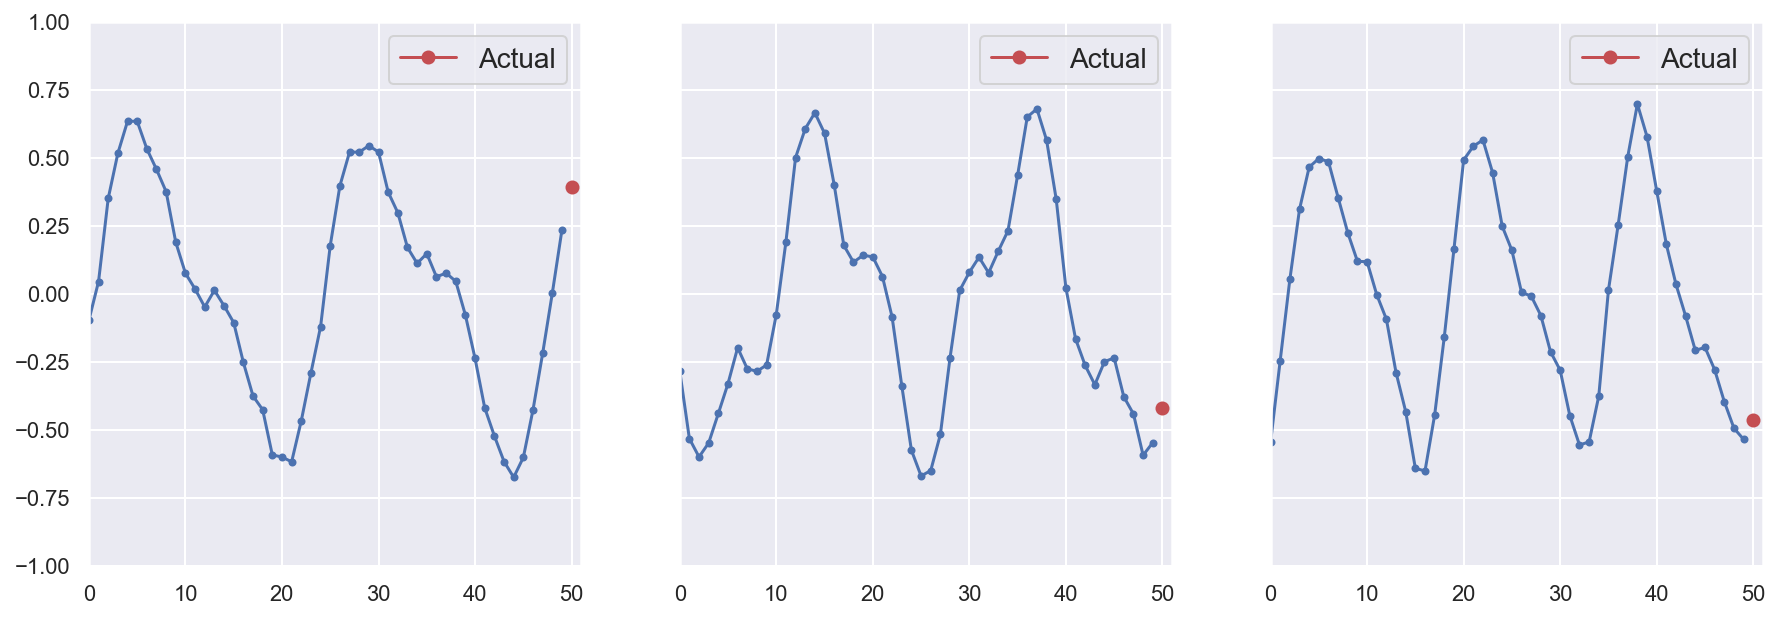

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))
for col in range(3):
    plt.sca(axes[col])
    plot_series(
        series=x_val[col, :, 0],
        y_true=y_val[col, 0],
        y_label=("$x(t)$" if col == 0 else None),
    )
plt.show()

### Naïve prediction

In [7]:
# Prediction = input for last time step
y_pred_naive = x_val[:, -1]
print(f"y_pred_naive: {y_pred_naive.shape}")

print(f"Naïve predictor MSE: {np.mean(mean_squared_error(y_val, y_pred_naive)):0.05f}")

y_pred_naive: (2000, 1)
Naïve predictor MSE: 0.02026


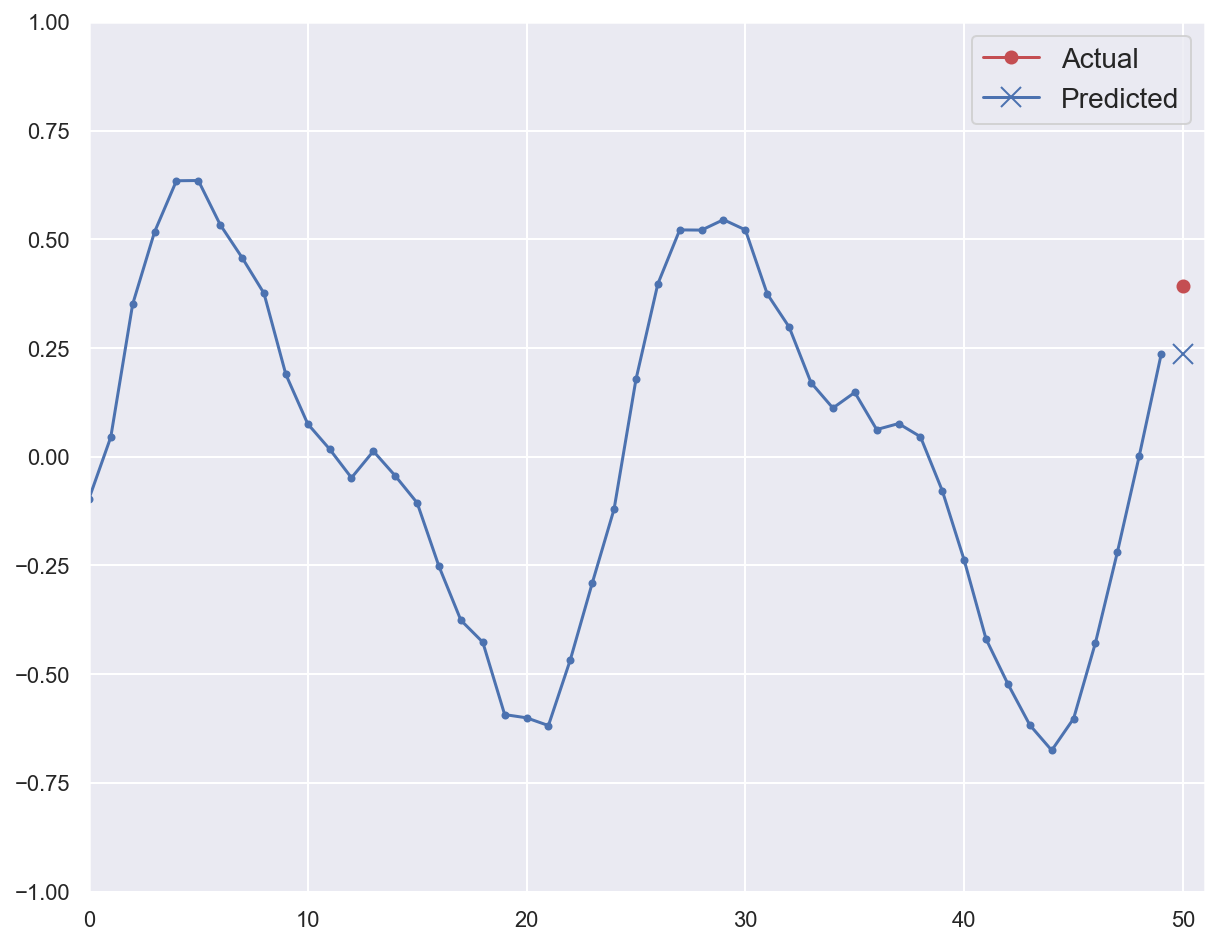

In [8]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred_naive[0, 0])
plt.show()

### Basic RNN

In [9]:
# Create a linear stack of layers
basic_rnn_model = Sequential()

# Add a RNN layer to the model
# units: dimensionality of the output space (= number of cells inside the layer)
# input_shape: dimensionality of input, excluding batch dimension: (time steps, features)
#   Could also be (n_steps, 1) here, bur RNN can process any number of time steps, so None is also ok
# This layer expects input as a 3D tensor (batch size, time steps, features)
# Output shape is a 2D tensor (batch size, units) corresponding to the last time step
# Activation function is tanh by default
basic_rnn_model.add(SimpleRNN(units=1, input_shape=(None, 1)))

# 1 weight for input, 1 for recurrent output, 1 for bias = 3 parameters
basic_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


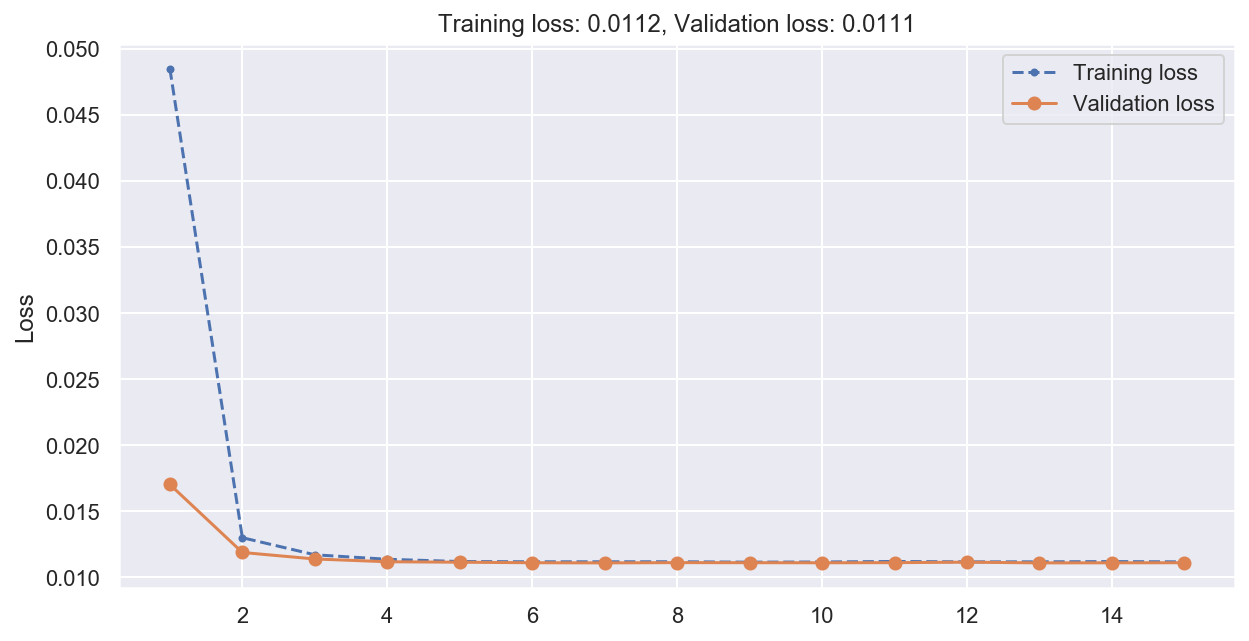

In [10]:
basic_rnn_model.compile(optimizer=Adam(lr=0.005), loss="mse")

history = basic_rnn_model.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [11]:
y_pred = basic_rnn_model.predict(x_val)

print(f"Basic RNN MSE: {np.mean(mean_squared_error(y_val, y_pred)):0.05f}")

Basic RNN MSE: 0.01110


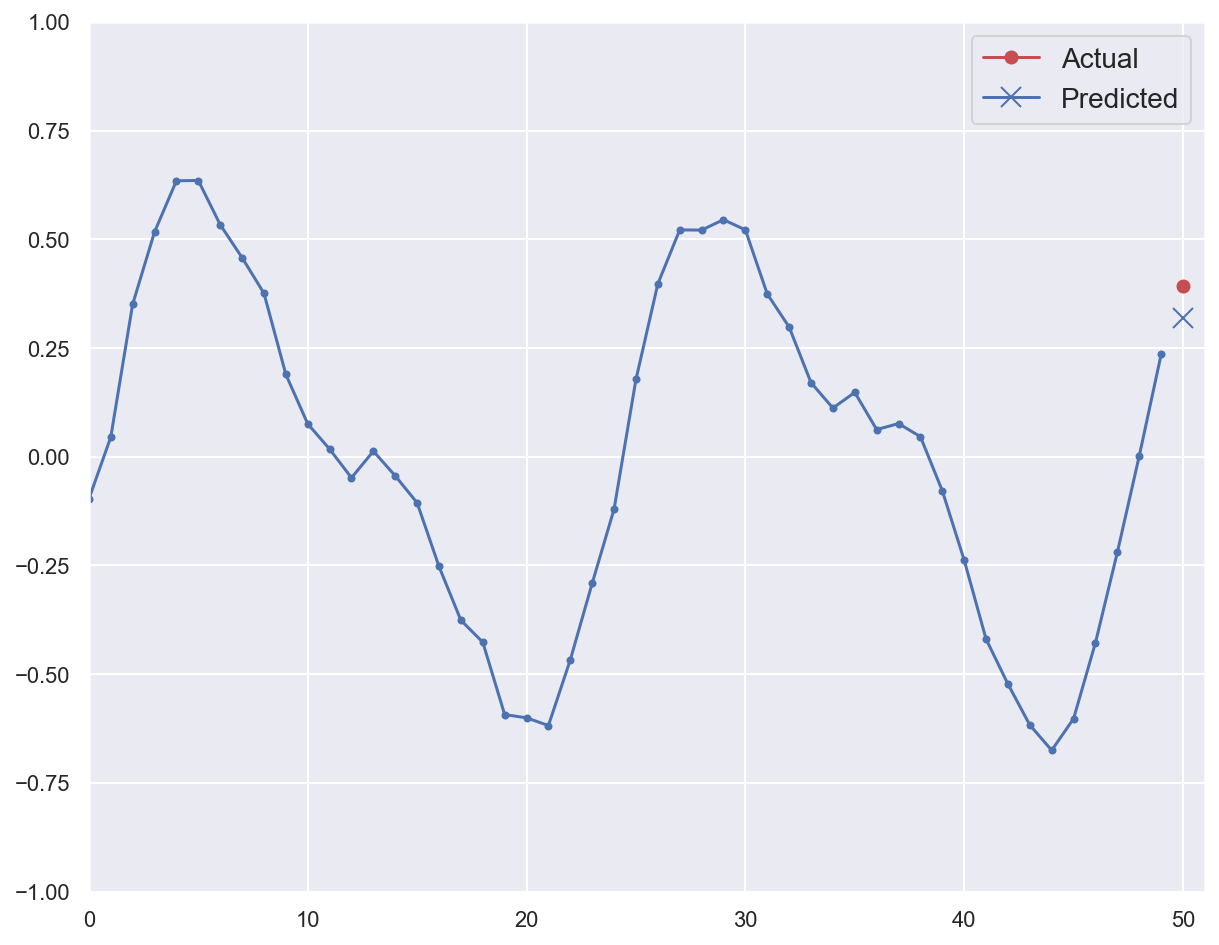

In [12]:
# Plot first validation series with ground truth and prediction
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred[0, 0])
plt.show()

### Deep RNN

In [13]:
deep_rnn_model_1 = Sequential()

# return_sequences: if True, the layer outputs the whole sequence instead of the value for last time step
# In that case, output shape is a 3D tensor (batch size, time steps, units)
deep_rnn_model_1.add(SimpleRNN(20, return_sequences=True, input_shape=(None, 1)))

# return_sequences is False by default
# In that case, output shape is a 2D tensor (batch size, units)
# Here, we only care about output for the last time step
deep_rnn_model_1.add(SimpleRNN(20))

# Add a linear layer to compute the prediction
deep_rnn_model_1.add(Dense(1))

# First RNN layer: 20 (input) + 20*20 (recurrent output) + 20 (bias) = 440 parameters
# Second RNN layer: 20*20 (input) + 20*20 (recurrent output) + 20 (bias) = 820 parameters
# Dense layer: 20 (input) + 1 (bias) = 21 parameters
deep_rnn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


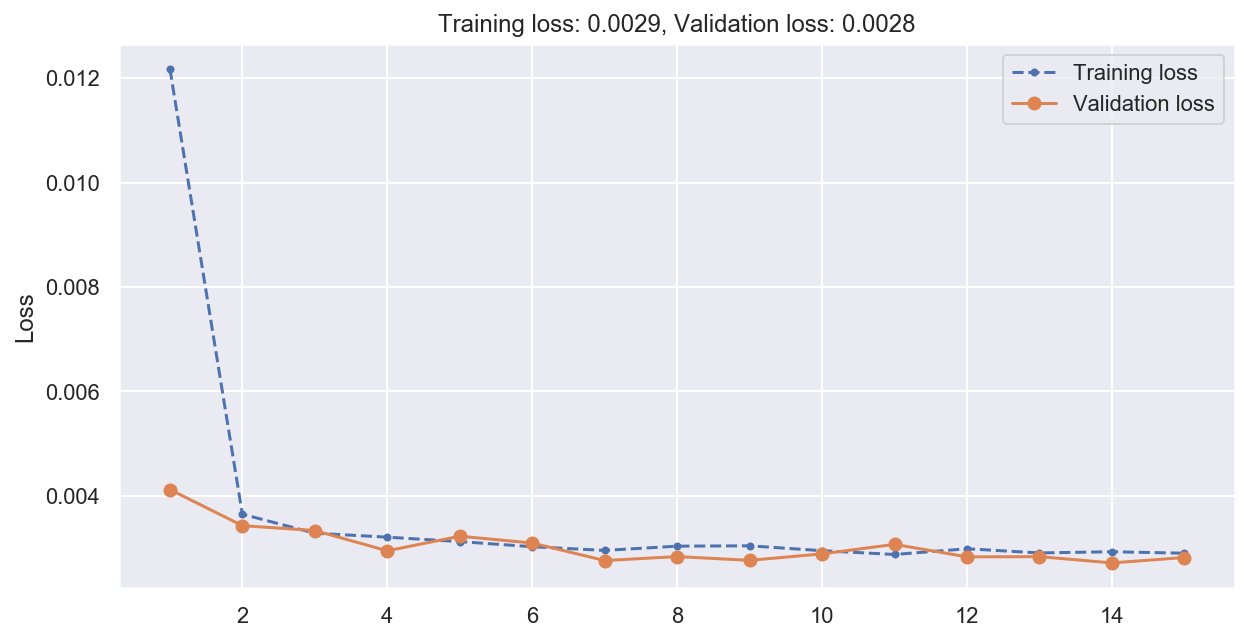

In [14]:
deep_rnn_model_1.compile(optimizer="adam", loss="mse")

history = deep_rnn_model_1.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

In [15]:
y_pred = deep_rnn_model_1.predict(x_val)

print(f"Deep RNN MSE: {np.mean(mean_squared_error(y_val, y_pred)):0.05f}")

Deep RNN MSE: 0.00282


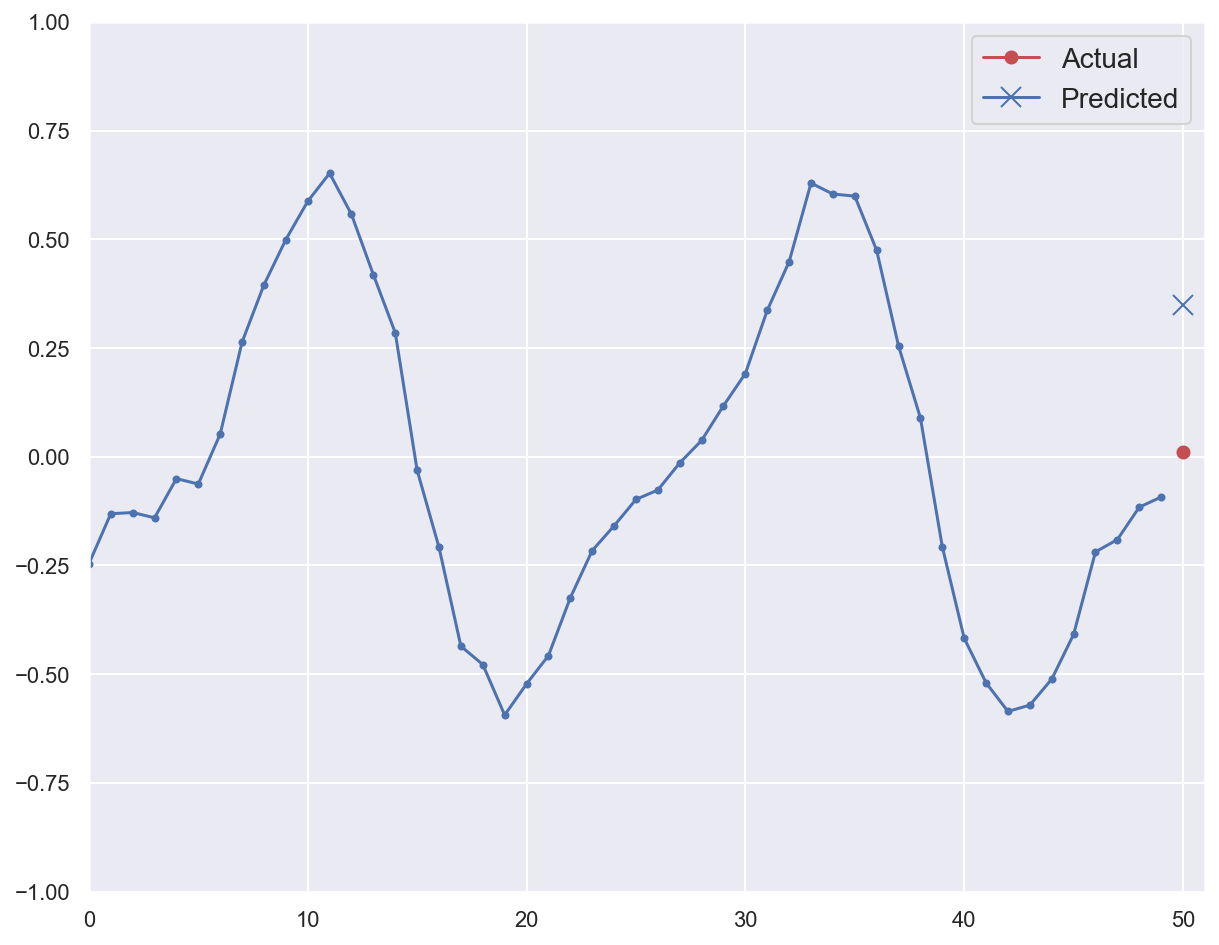

In [21]:
plot_series(series=x_val[0, :, 0], y_true=y_val[0, 0], y_pred=y_pred[0, 0])
plt.show()

### Predicting several steps ahead

In [17]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)

print(f"series: {series.shape}")

x_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
x_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val: {x_val.shape}, y_val: {y_val.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

series: (10000, 60, 1)
x_train: (7000, 50, 1), y_train: (7000, 10)
x_val: (2000, 50, 1), y_val: (2000, 10)
x_test: (1000, 50, 1), y_test: (1000, 10)


In [18]:
deep_rnn_model_2 = Sequential()
deep_rnn_model_2.add(SimpleRNN(20, return_sequences=True, input_shape=(None, 1)))
deep_rnn_model_2.add(SimpleRNN(20))
# Predict 10 steps ahead
deep_rnn_model_2.add(Dense(10))

deep_rnn_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


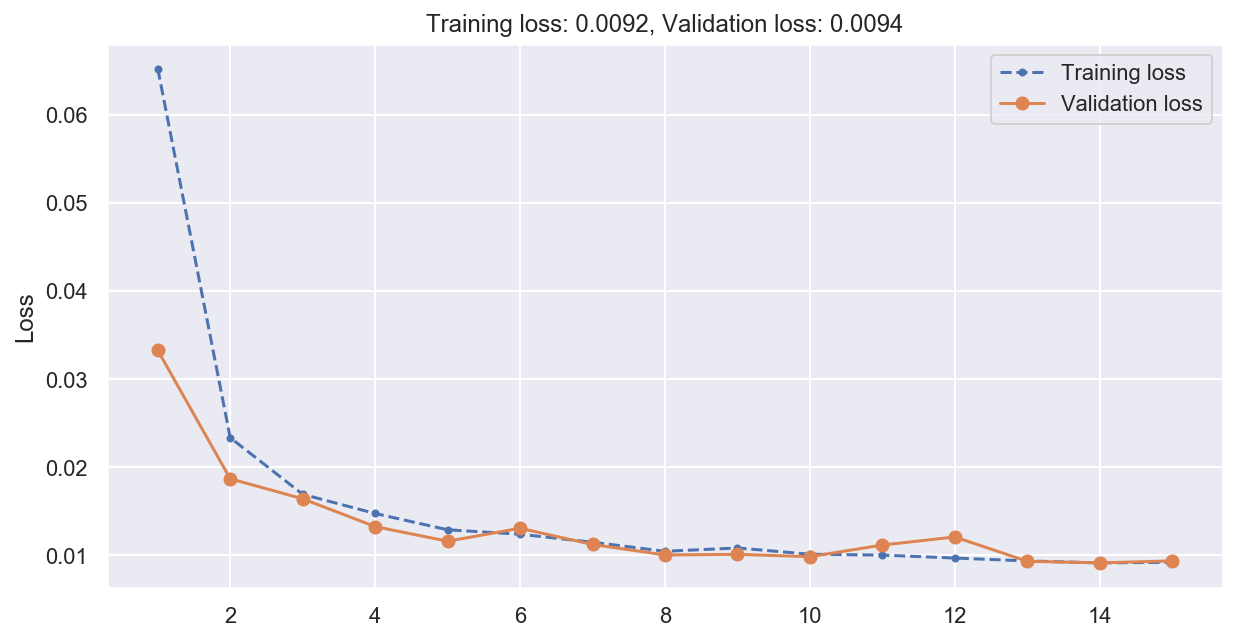

In [19]:
deep_rnn_model_2.compile(optimizer="adam", loss="mse")

history = deep_rnn_model_2.fit(
    x_train, y_train, epochs=15, verbose=0, validation_data=(x_val, y_val)
)

plot_loss(history)

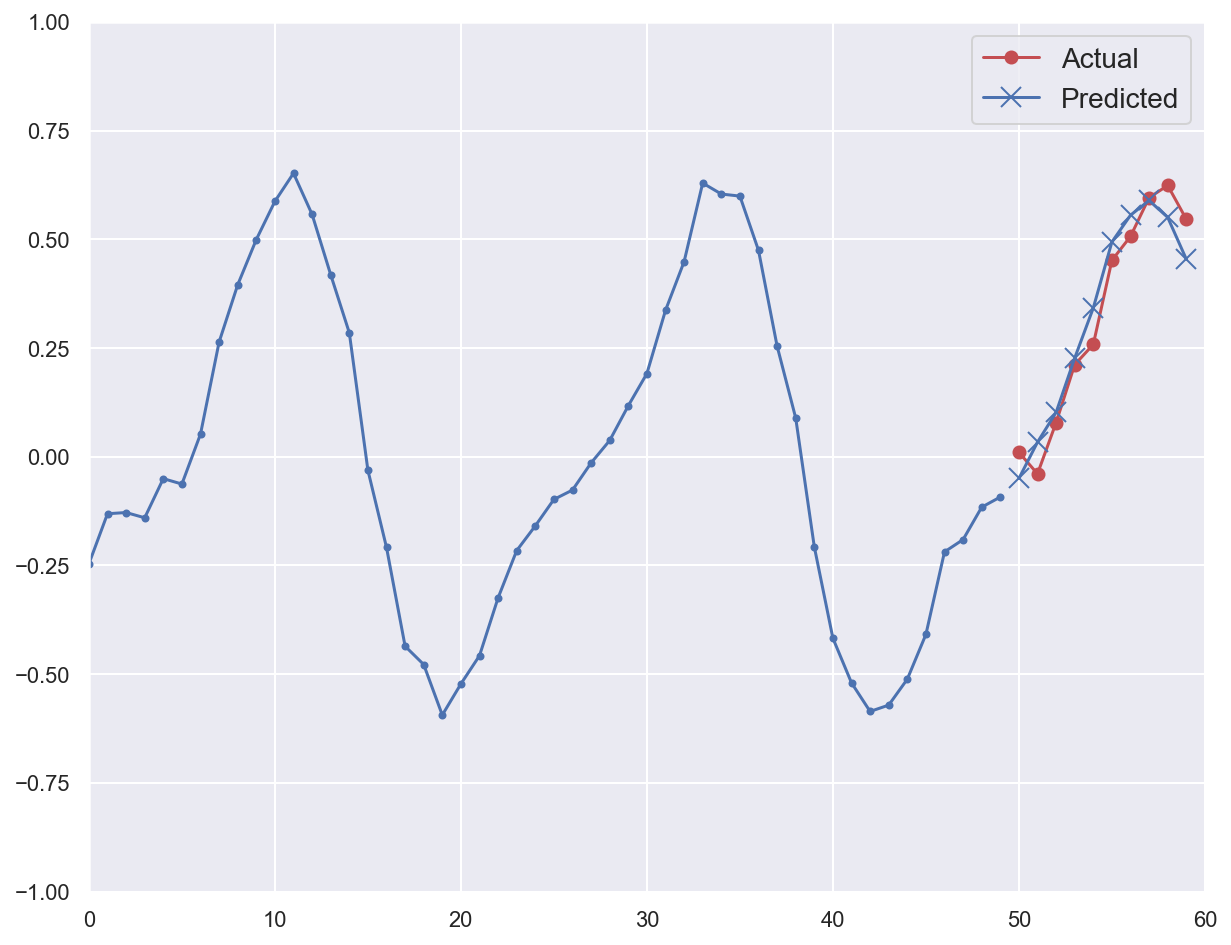

In [20]:
# Plot first validation series with ground truth and prediction
plot_series(
    series=x_val[0, :, 0], y_true=y_val[0], y_pred=deep_rnn_model_2.predict(x_val)[0]
)
plt.show()